https://github.com/google-research/vision_transformer [참고]

transformer encoder를 적게 사용하여 transformer encoder의 성능과 효과를 알아보자

 Vision Transformer의 동작 과정.
1. 입력된 이미지를 patch + position embedding을 한다.
2. embedding된 이미지 패치를 transformer encoder로 넣는다.
3. transformer encoder에 의해 encoding된 정보가 나온다.
4. MLP를 이용하여 출력 dimension을 조정 한다.

embedding시 dimension과 encoding시 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# tf.Module vs tf.keras.layers.Layer

In [62]:
#TODO 파이썬의 클래스, 상속/ 데코레이터 공부 필요

https://www.tensorflow.org/guide/intro_to_modules 참고

In [8]:
class Dense(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]),
            name='w'
        )
        self.b = tf.Variable(
            tf.zeros([out_features]),
            name='b'
        )

    def __call__(self, x):
        print(x.shape, self.w.shape, self.b.shape)
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.relu(y)

In [16]:
dense = Dense(in_features=3,out_features=2,name='test')
dense(tf.constant([[2.0,2.0,2.0]]))

(1, 3) (3, 2) (2,)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.8601856, 4.9089665]], dtype=float32)>

In [17]:
dense.variables

2022-10-27 17:24:13.330726: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


(<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
 array([[-0.7431357 ,  1.3614383 ],
        [-0.00665876,  0.9016345 ],
        [ 1.1798873 ,  0.19141059]], dtype=float32)>)

tf.Module을 사용하여 위와 같이 custom layer를 생성하면,
tf.Variable 또는 할당된 tf.Module 인스턴스를 재귀적으로 자동으로 수집한다. 
수집된 값은 (tf.Module).submodules나 (tf.Module).variables로 확인이 가능하다.
자동으로 수집된 값을 통해 단일 모델 인스턴스로 tf.Module 모음을 관리하고 전체 모델을 저장 및 로드할 수 있다.

하지만 init에서 변수의 크기를 지정하기 때문에 입출력의 길이가 정해진 상황에서만 사용할수 있다는 단점이 있다.
변수 생성을 연기함으로써 입력크기를 미리 지정하지 않아도 되도록 해보자!

In [18]:
class FlexibleDense(tf.Module):
    def __init__(self, out_features, name=None): # in_features를 고정하지 않음으로써 입력의 크기에 따라 변화 가능
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features

    def __call__(self, x):
        if not self.is_built: # call 할때마다 변수를 새로 만들면 안된다. 학습이 불가능해 질 것.
            self.w = tf.Variable(
                tf.random.normal([x.shape[-1], self.out_features]),
                name='w'
            )
            self.b = tf.Variable(
                tf.zeros([self.out_features]),
                name='b'
            )
            self.is_built = True

        y = tf.matmul(x,self.w)+self.b
        return tf.nn.relu(y)


앞서 가중치를 저장할 수 있다고 했는데 tf.train.Checkpoint를 이용하거나 tf.saved_model.save를 이용하면 된다.
여기서는 자세히 다루지 않으니 관심이 있다면 원문을 참고하거나 tensorflow document를 참고하자.

tensorflow는 original code없이 실행할 수 있는데, 이를 위해서는 코드를 그래프를 만들어야 한다.
TensorFlow needs to know how to do the computations described in Python, but without the original code.
해당 코드가 그래프로 실행되어야 함을 나타내기 위해서는 @tf.function 데코레이터를 사용하면 되는데
자세한 내용은 tensorflow document를 참고하자.

In [37]:
class KerasDense(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]),
            name='w'
        )
        self.b = tf.Variable(
            tf.zeros([out_features]),
            name='b'
        )

    def call(self, x):
        y = tf.matmul(x,self.w) + self.b
        return tf.nn.relu(y)        

In [38]:
kerasDense = KerasDense(in_features=3,out_features=2, name='test')
kerasDense(tf.constant([[2.0,2.0,2.0]]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.       , 1.7542236]], dtype=float32)>

하지만 위와 같은 형태는 앞선 tf.Module의 첫번째 예시와 같이 입력의 형태가 정해졌을 때(미리 알고 있을 때)만 사용가능하다.
입력의 형태(shape)에 맞게 w의 형태가 바뀌도록 코드를 수정해보자.

tf.keras.layers.Layer에는 build를 이용하여 앞서 말한것과 같은 유연성을 추가 할 수 있다.
tf.Module에서 사용한 self.is_built가 필요없고 build는 한번만 호출되며 호출될때 입력 형태가 입력으로 주어진다.
일반적으로 변수를 만들때 사용한다.
위의 코드를 build를 이용하여 수정해보면 다음과 같다.


In [52]:
class FlexibleKerasDense(tf.keras.layers.Layer):
    def __init__(self, out_features, name=None):
        super().__init__(name=name)
        self.out_features=out_features

    def build(self, input_shape):
        print("호출됨") # build가 언제 호출되는지 확인하기 위해 -> call하면 먼저 build가 호출됨.
        self.w = tf.Variable(
            tf.random.normal([input_shape[-1],self.out_features]),
            name='w'
        )
        self.b = tf.Variable(
            tf.zeros([self.out_features]),
            name='b'
        )

    def call(self, x):
        y = tf.matmul(x,self.w)+self.b
        return tf.nn.relu(y)

In [53]:
flexibleKerasDense = FlexibleKerasDense(out_features=3, name='test')
flexibleKerasDense.variables

[]

아직 build(변수를 생성하기)전 이므로 (tf.keras.layers.Layer).variables로 확인해보면 변수가 없음을 알수 있다.

In [54]:
flexibleKerasDense.build(input_shape=(1,3))

호출됨


In [55]:
flexibleKerasDense.variables

[<tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 1.8093308 ,  1.3985857 , -0.1626937 ],
        [ 0.69540864, -2.4313014 , -1.1886083 ],
        [-0.6576047 ,  0.08592828, -0.41285878]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

build를 통해 변수가 생성되었음을 알 수 있다.

In [56]:
flexibleKerasDense(tf.constant([[2.0,2.0,2.0]]))

호출됨


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.       , 6.2020826, 2.8126462]], dtype=float32)>

build는 한번 호출된다고 했는데 한번더 호출하면 어떻게 될까?

In [59]:
flexibleKerasDense.build(input_shape=(1,3))
flexibleKerasDense.variables

호출됨


[<tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
 array([[ 0.26520932, -1.2972199 ,  0.7670775 ],
        [ 0.2215567 , -0.7744951 , -1.1051631 ],
        [-0.09190309, -0.56559503, -1.2046446 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [60]:
flexibleKerasDense.build(input_shape=(1,4))
flexibleKerasDense.variables

호출됨


[<tf.Variable 'w:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.30019194,  1.1981277 , -2.585424  ],
        [-0.4498049 ,  1.5245918 ,  0.36952665],
        [-0.55717415, -1.2138438 ,  0.37801775],
        [-0.13454318,  0.47015575,  0.6181564 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [61]:
flexibleKerasDense(tf.constant([2.0,2.0,2.0]))
flexibleKerasDense.variables

InvalidArgumentError: Exception encountered when calling layer "test" (type FlexibleKerasDense).

In[0] and In[1] has different ndims: [3] vs. [4,3] [Op:MatMul]

Call arguments received:
  • x=tf.Tensor(shape=(3,), dtype=float32)

빌드를 호출하여 강제로 input_shape에 맞게 조절되도록 하면 변화하지만,<br>
빌드된 input_shape과 맞지 않는 형식의 input이 들어오면 입력이 거부된다.<br>


tf.keras.layers.Layer에는 다음과 같은 추가 기능이 있다. 참고하자.<br>
* Optional losses
* Support for metrics
* Built-in support for an optional training argument to differentiate between training and inference use
* get_config and from_config methods that allow you to accurately store configurations to allow model cloning in Python


다음은 tf.keras.Model이다.<br>
모델을 정의할때 functional 방식이나 sequential 방식을 통해 keras 레이어가 중첩된 상태로 정의할수도 있지만,<br>
keras에서 제공하는 모델 클래스도 있다.<br>
tf.keras.layers.Laer에서 상속되므로 tf.keras.Model은 tf.keras.layers.Layer에 해당하며 같은 방식으로 사용, 중첩 및 저장할 수 있다.<br>

tf.keras.Model에서 tf.Module에서와 같이 체크포인트를 사용할수도 있지만,<br>
(tf.keras.Model).save(저장경로)나 (tf.keras.Model).save_weights를 사용할 수도 있다.

### + 케라스 레이어에서 변수의 기준

In [219]:
class Add(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        self.w1 = tf.Variable(
        tf.random.normal([3, 4]), 
        name='w1',
        trainable=True)

    def build(self, input_shape):
        self.w2 = tf.Variable(
        tf.random.normal([3, 4]), 
        name='w2',
        trainable=True)

    def call(self,input):
        return input+self.w1

In [220]:
add = Add()

In [221]:
add.trainable_variables

[<tf.Variable 'w1:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.01372894,  1.7182862 ,  0.3679221 , -0.02330149],
        [ 0.77180237, -0.11622601,  0.97889197,  0.41070986],
        [-1.4942025 , -0.41123697,  0.18962502, -0.22718611]],
       dtype=float32)>]

In [222]:
add.trainable_weights

[<tf.Variable 'w1:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.01372894,  1.7182862 ,  0.3679221 , -0.02330149],
        [ 0.77180237, -0.11622601,  0.97889197,  0.41070986],
        [-1.4942025 , -0.41123697,  0.18962502, -0.22718611]],
       dtype=float32)>]

In [223]:
add.variables

[<tf.Variable 'w1:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.01372894,  1.7182862 ,  0.3679221 , -0.02330149],
        [ 0.77180237, -0.11622601,  0.97889197,  0.41070986],
        [-1.4942025 , -0.41123697,  0.18962502, -0.22718611]],
       dtype=float32)>]

In [225]:
add.build([1,4])

In [226]:
add.variables

[<tf.Variable 'w1:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.01372894,  1.7182862 ,  0.3679221 , -0.02330149],
        [ 0.77180237, -0.11622601,  0.97889197,  0.41070986],
        [-1.4942025 , -0.41123697,  0.18962502, -0.22718611]],
       dtype=float32)>,
 <tf.Variable 'w2:0' shape=(3, 4) dtype=float32, numpy=
 array([[-1.286846  ,  0.27606416, -1.220971  , -0.5353937 ],
        [ 0.32372358,  0.11204606,  1.1905655 , -0.52809995],
        [ 0.31775156,  1.2310293 , -0.28288323,  0.77270275]],
       dtype=float32)>]

# ViT

In [74]:
from PIL import Image
import numpy as np
from io import BytesIO
import requests

def preprocess_image(image):
    image = np.array(image)
    image_resized = tf.image.resize(image, (32, 32))
    image_resized = tf.cast(image_resized, tf.float32)
    image_resized = (image_resized - 127.5) / 127.5
    return tf.expand_dims(image_resized, 0).numpy()

def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image

img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

In [3]:
print(image.shape)
patches = tf.image.extract_patches(
    images=image,
    sizes=[1,16,16,1],
    strides=[1,16,16,1],
    rates=[1,1,1,1],
    padding='VALID'
)
print(patches.shape)

(1, 224, 224, 3)
(1, 14, 14, 768)


In [4]:
class Patches(tf.keras.layers.Layer):
    # batch image to batch image patches
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size # image를 크기가 몇인 정사각형 patch로 쪼개볼까
        self.patch_dim = patch_size*patch_size*3

    def build(self, input_shape): # (batch, height, width, channel)
        # create the state of the layer (weights)
        if input_shape[1] % self.patch_size != 0 or input_shape[2] % self.patch_size !=0 :
            print("이미지의 크기를 설정한 크기로 나눌수 없습니다.")
            print("input image shape: {}".format(input_shape))
            print("patch size setting: {}".format(self.patch_size))
            raise Exception()

    def call(self, inputs):
        patches = tf.image.extract_patches(inputs, 
                    sizes=[1,self.patch_size,self.patch_size,1], 
                    strides=[1,self.patch_size,self.patch_size,1],
                    rates=[1,1,1,1],
                    padding='VALID'
                )

        return patches

In [79]:
# reshape전 batch, 14, 14, patch별 dimension
make_patches = Patches(16)
patches = make_patches(image)
patches[:,1,1,:]

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.22769608, -0.2747549 , -0.38455883, -0.5579657 , -0.58933824,
        -0.6834559 , -0.68835783, -0.7197304 , -0.8060049 , -0.7278186 ,
        -0.751348  , -0.82193625, -0.5688726 , -0.592402  , -0.6629902 ,
        -0.5397059 , -0.5632353 , -0.6338235 , -0.41127452, -0.4269608 ,
        -0.5446078 , -0.54987746, -0.56556374, -0.6675245 , -0.44080883,
        -0.46433824, -0.5349265 , -0.76691175, -0.7982843 , -0.8688725 ,
        -0.8039216 , -0.8352941 , -0.92156863, -0.15294118, -0.18431373,
        -0.25490198, -0.11360294, -0.13713235, -0.19203432, -0.15821078,
        -0.1817402 , -0.23664215, -0.09276961, -0.10061274, -0.13982843,
        -0.08762255, -0.07977941, -0.12683824, -0.7420343 , -0.7655637 ,
        -0.83615196, -0.92965686, -0.9531863 , -0.9922794 , -0.86531866,
        -0.88884807, -0.94375   , -0.5634804 , -0.5870098 , -0.657598  ,
        -0.5908088 , -0.6143382 , -0.6692402 , -0.6305147 , -0.6540441 ,
 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


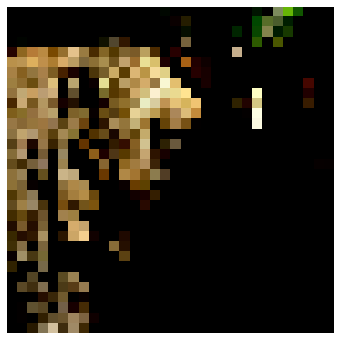

In [80]:
plt.figure(figsize=(6,6))
plt.imshow(image[0])
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


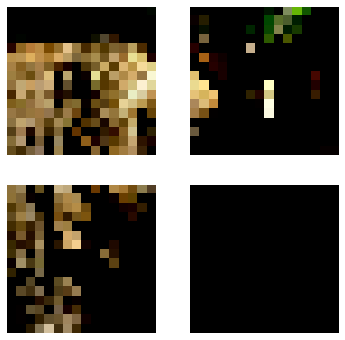

In [82]:
plt.figure(figsize=(6,6))
for i in range(2):
    for j in range(2):
        patch = tf.reshape(patches[:,i,j,:],[16,16,3]).numpy()
        plt.subplot(2,2,i*2+j+1)
        plt.axis('off')
        plt.imshow(patch)
plt.show()   

In [8]:
make_patches.variables

[]

In [11]:
# Patch Embedding에 통합됨

class PatchProjection(tf.keras.layers.Layer):
    # equal to a dense layer without bias and activation
    # just embedding matrix = tf.keras.layers.Embedding
    # NOTE in hybrid architecture, patch projection is replaced with CNN feature extractor
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        
    def call(self, inputs):
        patches = self.make_patches(inputs)
        patch_shape = patches.shape
        patch_nums = patch_shape[1]*patch_shape[2]
        
        y = self.projection(patches)
        return y      


In [ ]:
variable = tf.Variable(tf.random.normal([1,1,10]))

In [164]:
tf.keras.initializers.GlorotNormal()

In [155]:
class PatchEmbedding(tf.keras.layers.Layer):
    # 1. add dummy patch and project patches to projection dimension 
    # 2. attach position embeddings to each patches 
    # NOTE add extra learnable class embedding to dummy patch

    def __init__(self, projection_dim, dropout_rate, **kwargs):
        super().__init__( **kwargs)
        self.projection_dim = projection_dim
        self.projection = tf.keras.layers.Dense(units=self.projection_dim, trainable=True)     
        self.dropout = tf.keras.layers.Dropout(dropout_rate)   
        self.class_token = tf.keras.initializers.GlorotNormal()

    def build(self,input_shape): 
        # input_shape는 (batch, patch수, patch별 dimension)
        self.patch_nums = input_shape[1]
        self.batch_size = input_shape[0]
        self.position_embedding = tf.keras.layers.Embedding(input_dim=self.patch_nums, output_dim=self.projection_dim, trainable=True)
        self.class_token = tf.Variable(
            tf.random.normal([1,1, self.projection_dim]),# from BERT / TODO normal(stddev=0.02)
            trainable=True,
            name='class token (=projected dummy patch)',
            dtype=tf.float32
        )

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.patch_nums+1)                  # class token을 위해 +1
        y1 = self.projection(inputs)                                            # batch, patch개수, projection dimension
        self.class_token = tf.cast(self.class_token, tf.float32)
        
        print("class token:",self.class_token.shape)
        print("y1 shape:", y1.shape)
        print("input batch size:",self.batch_size)
        if self.batch_size != 1:# 여기가 None인 경우가 있어 의도대로 처리가 안될수도
        #NOTE broadcasting을 BATCH_SIZE로 고정하면서 이미지 하나가 들어오는 상황을 처리 못함.
            print("class token need broadcast to batch axis")
            print("type of class token:", type(self.class_token))
            self.class_token = tf.broadcast_to(self.class_token, shape=[BATCH_SIZE,1,self.projection_dim])
            print("class token:",self.class_token.shape)
            
        y1 = tf.concat([self.class_token,y1], axis=1)                           # batch, patch개수 + 1, projeciton dimension
        print("number of patches after add dummy class patch:", y1.shape)
        print("y1:",y1.shape)
        y2 = self.position_embedding(positions)
        output = y1+y2
        output = self.dropout(output)
        return output


In [83]:
A = tf.ones([1,1,100])
tf.broadcast_to(A, [256,1,100])

<tf.Tensor: shape=(256, 1, 100), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [141]:
patchEmbedding = PatchEmbedding(projection_dim=100,name='patch embedding')

In [129]:
patchEmbedding.variables

[]

In [142]:
reshaped_patches = tf.reshape(patches, [-1,2*2, patches.shape[-1]])
print(patches.shape, "->", reshaped_patches.shape)
embedded_patches = patchEmbedding(reshaped_patches)

(1, 2, 2, 768) -> (1, 4, 768)
class token: (1, 1, 100)
y1 shape: (1, 4, 100)
input batch size: 1
number of patches after add dummy class patch: (1, 5, 100)
y1: (1, 5, 100)


In [143]:
len(patchEmbedding.variables) 
# expect 4 (dense kernel, dense bias, embedding kernel, class token)

4

In [ ]:
# keras의 multiheadattention layer 사용
# transformer encoder에 통합됨

class MSA(tf.keras.layers.Layer):

    def __init__(self, heads_num, key_dim,**kwargs):
        super().__init__(**kwargs)
        self.heads_num = heads_num
        self.key_dim = key_dim

        self.initializer = tf.keras.initializers.RandomNormal()
        

    def build(self, input_shape):
        # input shape (batch, patch개수+1, patch별 dimension)

        self.m_qkv = tf.Variable(
            self.initializer(input_shape[-1], self.key_dim),
            name="qkv matrix",
            trainable=True
        )
        

    def call(self, inputs):
        qkv = tf.matmul(inputs, self.m_qkv)
        print(qkv.shape)
        q = 
        k = 
        v = 

multihead attention layer를 이해해보자 <br>
multihead self attention으로 만들기 위해서는 attention layer의 target과 source에 같은 값을 넣으면 됨.<br>

In [51]:
attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=50, value_dim=100 ,use_bias=False, attention_axes=(2), output_shape=(100))
input = tf.keras.Input(shape=[167, 100])
attention_output, attention_scores = attention_layer(input, input,
                               return_attention_scores=True)
print(attention_output.shape)
print(attention_scores.shape)


(None, 167, 100)
(None, 167, 8, 8)


In [53]:
attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=50, value_dim=50 ,use_bias=False, attention_axes=(2))
norm_patches = tf.keras.layers.LayerNormalization()(embedded_patches)
output_tensor, weights = attention_layer(norm_patches, norm_patches,
                               return_attention_scores=True)
print(output_tensor.shape)
print(weights.shape)

(1, 197, 100)
(1, 197, 8, 8)


In [54]:
len(attention_layer.variables) #W_k, W_q, W_v, W_o

4

In [55]:
class MLP(tf.keras.layers.Layer):
    # MLP layer for transformer encoder
    # two layers with a GELU non-linearity

    # dense-gelu-dropout-dense-dropout
    def __init__(self, output_size, **kwargs):
        super().__init__(**kwargs)
        self.output_size = output_size
        self.dense_1 = tf.keras.layers.Dense(output_size, activation=tf.nn.gelu, trainable=True)
        self.dense_2 = tf.keras.layers.Dense(output_size, activation=tf.nn.gelu, trainable=True)
        # TODO kernel은 xavier uniform/ bias는 normal(stddev=1e-6)

    def call(self, inputs):
        y = self.dense_1(inputs)
        y = self.dense_2(y)
        return y

In [56]:
mlp = MLP(100)
mlp.variables

[]

In [57]:
mlp(tf.constant([[2,2,2]]))
len(mlp.variables)

4

In [58]:
class TransformerEncoder(tf.keras.layers.Layer):
    # input : embedded patches (batch, patch개수+1, projection_dim)
    # logic : norm -> MSA -> (skip-connection) -> norm -> MLP -> (skip-connection)
    # NOTE MSA is global and MLP is local

    def __init__(self, heads_num, hidden_dim, output_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.heads_num = heads_num
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout

        self.norm = tf.keras.layers.LayerNormalization(axis=2)
        
        
    def build(self, input_shape):
        # create the state of the layer (weights)
        # print("output_shape:",(-1,input_shape[1],self.hidden_dim) )
        self.MSA = tf.keras.layers.MultiHeadAttention( # TODO xavier_uniform/ broadcast dropout=False
            num_heads=self.heads_num, 
            key_dim=self.hidden_dim, 
            value_dim=self.hidden_dim, 
            
            dropout=self.dropout, 
            use_bias=False, 
            #output_shape=(-1,input_shape[1],self.hidden_dim),
            attention_axes=(1,2),

            kernel_initializer=tf.keras.initializers.GlorotNormal(), # called Xavier normal 
            trainable = True
        )
        self.mlp = MLP(self.output_dim)

    def call(self, inputs):
        norm1 = self.norm(inputs)                                                       # shape변화가 생기진 않음. (batch, patch수+1, projection_dim)
        attention_output, attention_scores = self.MSA(norm1, norm1, return_attention_scores=True)
        # print("inputs shape:", inputs.shape)
        # print("attention_output shape:", attention_output.shape)
        skip_connection1 = attention_output+inputs

        norm2 = self.norm(skip_connection1)
        mlp = self.mlp(norm2)
        # print("skip connection:", skip_connection1.shape)
        # print("mlp output:", mlp.shape)
        output = mlp + skip_connection1
        
        return output
    

In [59]:
transformer = TransformerEncoder(heads_num=8,hidden_dim=50,output_dim=100,dropout=0.5)
transformer(embedded_patches)

<tf.Tensor: shape=(1, 197, 100), dtype=float32, numpy=
array([[[-0.83978915,  0.11540891,  0.8937869 , ...,  0.00642251,
          1.0879207 ,  0.7042538 ],
        [ 0.76290274, -1.2995269 , -0.7969871 , ..., -0.3934379 ,
         -0.05691993, -0.26764238],
        [ 0.6531043 , -1.2234181 , -0.66665035, ..., -0.15550154,
          0.09102231, -0.32065767],
        ...,
        [ 0.12630479,  0.23560578, -0.38768417, ..., -0.1849199 ,
          0.319824  ,  0.67517996],
        [ 0.09697765,  0.37452912, -0.35579357, ..., -0.22407901,
          0.4779696 ,  0.6551471 ],
        [ 0.13296945,  0.04415721, -0.4646786 , ..., -0.21531425,
          0.31047422,  0.6736077 ]]], dtype=float32)>

In [60]:
len(transformer.variables) # 2 for layer norm/ 4 for MSA/ 4 for MLP

10

In [61]:
transformer.variables

[<tf.Variable 'transformer_encoder/layer_normalization_2/gamma:0' shape=(100,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32)>,
 <tf.Variable 'transformer_encoder/layer_normalization_2/beta:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

In [62]:
INPUT_SHAPE = (32,32,3)
PATCH_SIZE = 8
PATCH_NUM = 4*4

PROJECTION_DIM = 100
HIDDEN_DIM = 50

TRANSFORMER_LAYERS = 1
TRANSFORMER_HEADS = 2
TRANSFORMER_DROPOUT = 0

CLASS_NUM=100

EPOCHS =10
LEARNING_RATE = 0.03
BATCH_SIZE = 256


In [63]:
# functional version model

def ViT():
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    patches = Patches(patch_size=PATCH_SIZE)(inputs)
    print(patches.shape)
    reshaped_patches = tf.reshape(patches, [-1,PATCH_NUM, patches.shape[-1]])
    print(reshaped_patches.shape)
    embedded_patches = PatchEmbedding(projection_dim=PROJECTION_DIM)(reshaped_patches)

    for _ in range(TRANSFORMER_LAYERS):
        embedded_patches = TransformerEncoder(TRANSFORMER_HEADS, HIDDEN_DIM, PROJECTION_DIM, dropout=TRANSFORMER_DROPOUT)(embedded_patches) 
        # shape변화 없음 (batch, patch수+1, projection_dim)   

    class_token = embedded_patches[:,0,:] #(batch, 1, projection_dim)
    # print(class_token.shape)
    outputs = tf.keras.layers.Dense(CLASS_NUM)(class_token)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model



In [156]:
vision_transformer = ViT()

(None, 4, 4, 192)
(None, 16, 192)
class token: (1, 1, 100)
y1 shape: (None, 16, 100)
input batch size: None
class token need broadcast to batch axis
type of class token: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
class token: (256, 1, 100)
number of patches after add dummy class patch: (256, 17, 100)
y1: (256, 17, 100)


In [115]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [159]:
vision_transformer.build(input_shape=(BATCH_SIZE,32,32,3))

In [162]:
# NOTE variable 개수가 16이어야 될거 같은데?
print(len(vision_transformer.variables))
vision_transformer.variables

# 2 : position embedding
# 1 : projection 
# 1 : learnable class token
# 2*layer : transformer layer norm (gamma,beta)
# 2*2*layer : transformer MLP
# 4*layer : transformer MSA (key,query,value,output)
# 2 : dense for output

15


[<tf.Variable 'patch_embedding_23/dense_46/kernel:0' shape=(192, 100) dtype=float32, numpy=
 array([[-0.02888576, -0.01962403, -0.06711025, ...,  0.01903354,
          0.05218753,  0.01535675],
        [ 0.03745648,  0.06046556,  0.10148868, ...,  0.13890259,
          0.08158727, -0.13207778],
        [-0.08929653,  0.13263933,  0.09741402, ...,  0.10726754,
         -0.07365435,  0.08052213],
        ...,
        [-0.13814443, -0.0285105 , -0.05893788, ...,  0.12152793,
          0.13371743,  0.02527665],
        [ 0.12740706, -0.01399718,  0.07934046, ..., -0.1234666 ,
         -0.08427311,  0.10695146],
        [ 0.02495119,  0.07661723,  0.11465655, ...,  0.0265355 ,
         -0.09704757, -0.12146619]], dtype=float32)>,
 <tf.Variable 'patch_embedding_23/dense_46/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [ ]:
class ViT(tf.keras.Model):
    def __init__(self, patch_size, projection_dim, hidden_dim, transformer_layer_num, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim

        self.transformer_layer_num = transformer_layer_num

        self.make_patch = Patches(patch_size)
        self.patch_embedding = PatchEmbedding(projection_dim=100)
        self.transformer_layer = TransformerEncoder

    def call(self, inputs):
        # image to patches and reshape for projection

        # projection and position embedding

        # transformer layer


    

In [160]:
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
vision_transformer.compile(
    optimizer=optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy')
    ],    
) # 정답이 one_hot으로 되어있다는 뜻


In [163]:
history = vision_transformer.fit(
    x=x_train,
    y=y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/10
class token: (256, 1, 100)
y1 shape: (None, 16, 100)
input batch size: None
class token need broadcast to batch axis
type of class token: <class 'tensorflow.python.framework.ops.Tensor'>
class token: (256, 1, 100)
number of patches after add dummy class patch: (256, 17, 100)
y1: (256, 17, 100)
class token: (256, 1, 100)
y1 shape: (None, 16, 100)
input batch size: None
class token need broadcast to batch axis
type of class token: <class 'tensorflow.python.framework.ops.Tensor'>
class token: (256, 1, 100)
number of patches after add dummy class patch: (256, 17, 100)
y1: (256, 17, 100)


TypeError: <tf.Tensor 'model_6/patch_embedding_23/BroadcastTo:0' shape=(256, 1, 100) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'model_6/patch_embedding_23/BroadcastTo:0' shape=(256, 1, 100) dtype=float32> was defined here:
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/traitlets/config/application.py", line 965, in launch_instance
      app.start()
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/cvnar1/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/cvnar1/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_532391/3003937714.py", line 1, in <cell line: 1>
      history = vision_transformer.fit(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
      result = self._call(*args, **kwds)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 963, in _call
      self._initialize(args, kwds, add_initializers_to=initializers)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 785, in _initialize
      self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 2983, in _get_concrete_function_internal_garbage_collected
      graph_function, _ = self._maybe_define_function(args, kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3292, in _maybe_define_function
      graph_function = self._create_graph_function(args, kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 3130, in _create_graph_function
      func_graph_module.func_graph_from_py_func(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1161, in func_graph_from_py_func
      func_outputs = python_func(*func_args, **func_kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py", line 677, in wrapped_fn
      out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 1136, in autograph_handler
      return autograph.converted_call(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 1312, in run
      return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 2888, in call_for_each_replica
      return self._call_for_each_replica(fn, args, kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3689, in _call_for_each_replica
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_532391/3443066435.py", line 31, in call
      if self.batch_size != 1:# 여기가 None인 경우가 있어 의도대로 처리가 안될수도
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 1321, in if_stmt
      _py_if_stmt(cond, body, orelse)
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py", line 1374, in _py_if_stmt
      return body() if cond else orelse()
    File "/tmp/ipykernel_532391/3443066435.py", line 35, in call
      self.class_token = tf.broadcast_to(self.class_token, shape=[BATCH_SIZE,1,self.projection_dim])
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py", line 876, in broadcast_to
      _, _, _op, _outputs = _op_def_library._apply_op_helper(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 740, in _apply_op_helper
      op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py", line 693, in _create_op_internal
      return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 3776, in _create_op_internal
      ret = Operation(
    File "/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2175, in __init__
      self._traceback = tf_stack.extract_stack_for_node(self._c_op)

The tensor <tf.Tensor 'model_6/patch_embedding_23/BroadcastTo:0' shape=(256, 1, 100) dtype=float32> cannot be accessed from here, because it was defined in FuncGraph(name=train_function, id=139779717021216), which is out of scope.